In [3]:
from torch import nn
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import torch.optim as optim
import torchvision
import numpy as np
import json
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import glob
import cv2
from torchsummary import summary
import copy
from mpl_toolkits.axes_grid import ImageGrid
from tqdm.notebook import tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
JSON_PATH = "dataset/annotation-small.json"
IMAGE_PATH = "dataset/images/"
ROWS, COL = (300, 300)

In [6]:
annotation_data = None

with open(JSON_PATH, "r") as f: 
    annotation_data = json.load(f)


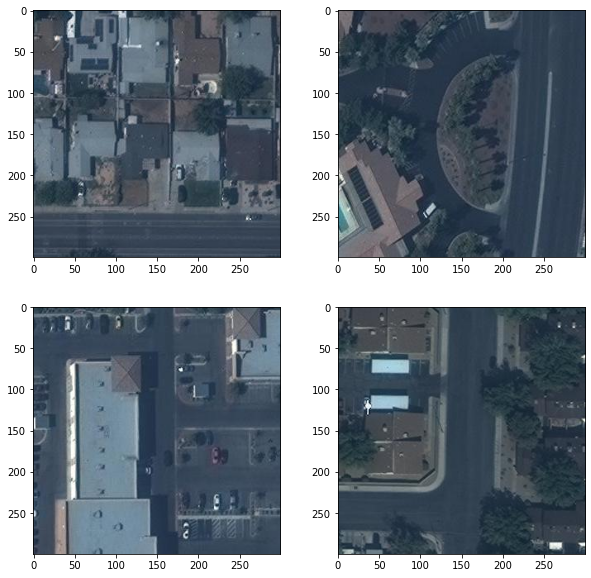

In [7]:
image_df = pd.DataFrame(annotation_data["images"])
image_df.sample(3)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))

for ax, (_, row) in zip(axis.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(IMAGE_PATH, row["file_name"]))
    ax.imshow(img_data)


In [8]:
annotation_df = pd.DataFrame(annotation_data["annotations"])
annotation_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
14557,200900,23535,"[[239.0, 116.0, 212.0, 106.0, 211.0, 108.0, 18...",2315.0,"[97.0, 181.0, 142.0, 81.0]",100,0
3161,18924,2175,"[[85.0, 113.0, 74.0, 113.0, 74.0, 74.0, 86.0, ...",2767.0,"[74.0, 74.0, 78.0, 78.0]",100,0
10029,468925,54805,"[[251.0, 224.0, 251.0, 212.0, 249.0, 212.0, 24...",2148.0,"[189.0, 249.0, 68.0, 51.0]",100,0


In [9]:
full_df = pd.merge(
    annotation_df, image_df, how="left", left_on="image_id", right_on="id"
).dropna()
print(image_df.shape[0], "+", annotation_df.shape[0], "->", full_df.shape[0])

full_df.sample(2)


1820 + 15770 -> 15770


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
2791,38413,4480,"[[105.00000000000001, 247.0, 171.0, 247.0, 171...",3066.0,"[105.00000000000001, 105.00000000000001, 183.0...",100,0,4480,000000004480.jpg,300,300
121,472961,55279,"[[145.0, 286.0, 166.0, 286.0, 166.0, 275.0, 17...",1788.0,"[145.0, 145.0, 141.0, 69.0]",100,0,55279,000000055279.jpg,300,300


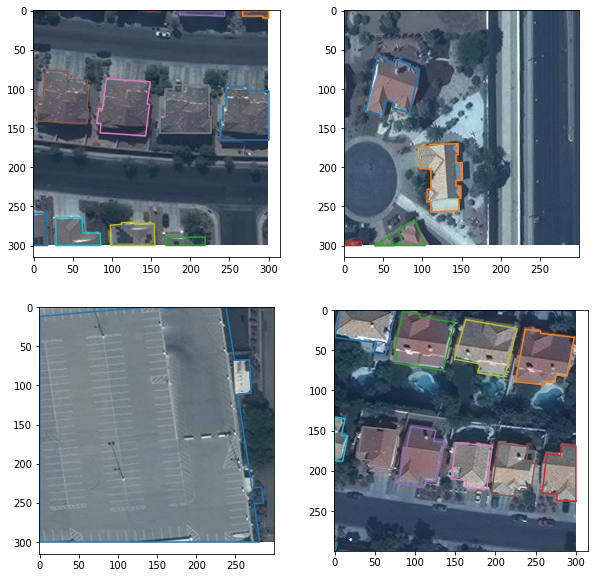

In [10]:
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, (id, df) in zip(m_axs.flatten(), full_df.groupby("image_id")):
    img_data = imread(os.path.join(IMAGE_PATH, df["file_name"].values[0]))
    ax.imshow(img_data)
    for _, row in df.iterrows():
        xy_vec = np.array(row["segmentation"]).reshape((-1, 2))
        ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=df["id_x"])


In [11]:
from matplotlib.path import Path
from skimage.color import label2rgb


def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing="ij")
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row["segmentation"]).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=c_df["id_x"])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(
            np.stack([yy.ravel(), xx.ravel()], -1)
        ).reshape(out_img.shape)
    return out_img


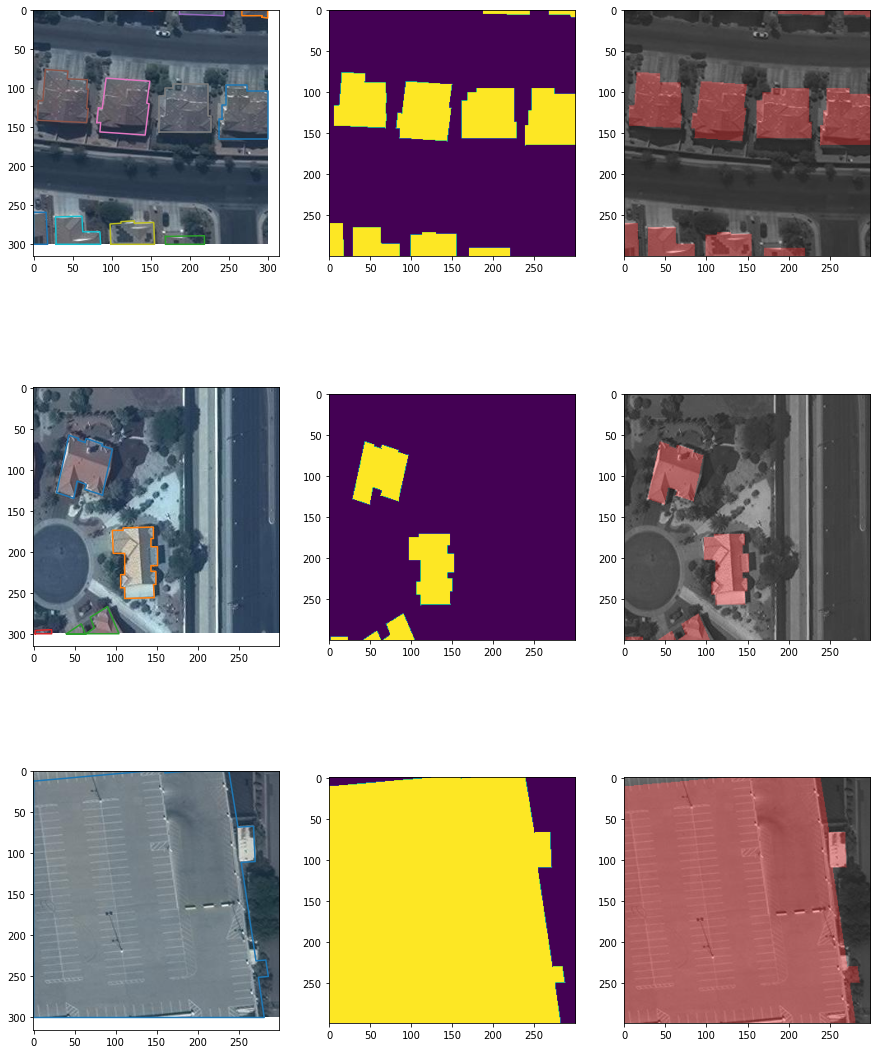

In [12]:
fig, m_axs = plt.subplots(3, 3, figsize=(15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs, full_df.groupby("image_id")):
    img_data = imread(os.path.join(IMAGE_PATH, c_df["file_name"].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    d_ax.imshow(out_img)
    rgba_img = np.concatenate(
        [
            img_data,
            np.clip(np.expand_dims(127 * out_img + 127, -1), 0, 255).astype(np.uint8),
        ],
        -1,
    )
    # d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label=0))


In [14]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(image_df["id"], test_size=0.25)
train_df = full_df[full_df["image_id"].isin(train_ids)]
valid_df = full_df[full_df["image_id"].isin(valid_ids)]
print(train_df.shape[0], "training boxes")
print(valid_df.shape[0], "validation boxes")


11862 training boxes
3908 validation boxes


In [15]:
train_df.head()

,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
1,446305,52178,"[[257, 123, 243, 123, 243, 112, 257, 112, 257,...",154.0,"[123, 243, 134, 14]",100,0,52178,000000052178.jpg,300,300
4,305540,35813,"[[300, 128, 293, 128, 300, 94, 300, 128]]",120.0,"[128, 293, 172, 7]",100,0,35813,000000035813.jpg,300,300
5,251004,29395,"[[258.0, 38.0, 271.0, 0.9999999999999716, 282....",1749.0,"[-2.842170943040401e-14, 258.0, 300.0, 42.0]",100,0,29395,000000029395.jpg,300,300
7,171663,20137,"[[116, 86, 99, 86, 99, 68, 116, 68, 116, 66, 1...",2275.0,"[66, 99, 50, 64]",100,0,20137,000000020137.jpg,300,300
8,347326,40728,"[[268.0, 7.225416114969383e-15, 268.0, 4.00000...",70.0,"[7.225416114969383e-15, 248.0, 268.0, 20.0]",100,0,40728,000000040728.jpg,300,300


In [12]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby("image_id"))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(IMAGE_PATH, c_df["file_name"].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(
                    out_seg, 0
                ).astype(np.float32)
                out_img, out_seg = [], []


valid_gen = batch_img_gen(valid_df, 8)


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


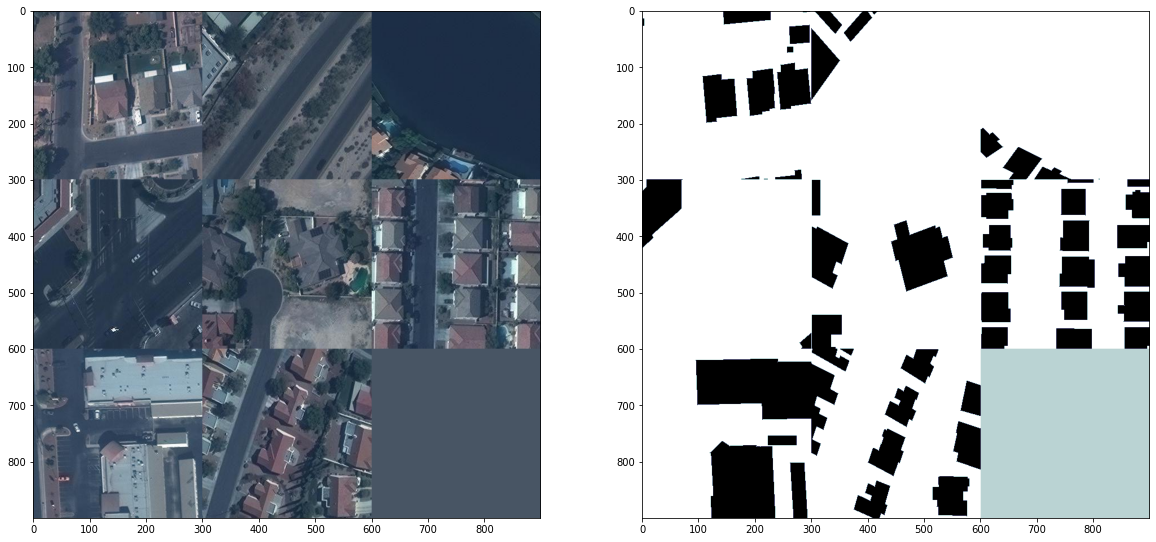

In [14]:
from skimage.util import montage

t_x, t_y = next(valid_gen)
print("x", t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print("y", t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
montage_rgb = lambda x: np.stack(
    [montage(x[:, :, :, i]) for i in range(x.shape[3])], -1
)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap="bone_r")


<h1>Unet ResNet model</h1>

In [ ]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
            Paramaters for Deconvolution were chosen to avoid artifacts, following
            link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(
                    middle_channels, out_channels, kernel_size=4, stride=2, padding=1
                ),
                nn.ReLU(inplace=True),
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear"),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNetResNet(nn.Module):
    """PyTorch U-Net model using ResNet(34, 101 or 152) encoder.

    UNet: https://arxiv.org/abs/1505.04597
    ResNet: https://arxiv.org/abs/1512.03385
    Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

    Args:
            encoder_depth (int): Depth of a ResNet encoder (34, 101 or 152).
            num_classes (int): Number of output classes.
            num_filters (int, optional): Number of filters in the last layer of decoder. Defaults to 32.
            dropout_2d (float, optional): Probability factor of dropout layer before output layer. Defaults to 0.2.
            pretrained (bool, optional):
                False - no pre-trained weights are being used.
                True  - ResNet encoder is pre-trained on ImageNet.
                Defaults to False.
            is_deconv (bool, optional):
                False: bilinear interpolation is used in decoder.
                True: deconvolution is used in decoder.
                Defaults to False.

    """

    def __init__(
        self,
        encoder_depth,
        num_classes,
        num_filters=32,
        dropout_2d=0.2,
        pretrained=False,
        is_deconv=False,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d = dropout_2d

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError(
                "only 34, 101, 152 version of Resnet are implemented"
            )

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(
            self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.pool
        )

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(
            bottom_channel_nr, num_filters * 8 * 2, num_filters * 8, is_deconv
        )
        self.dec5 = DecoderBlockV2(
            bottom_channel_nr + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec4 = DecoderBlockV2(
            bottom_channel_nr // 2 + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec3 = DecoderBlockV2(
            bottom_channel_nr // 4 + num_filters * 8,
            num_filters * 4 * 2,
            num_filters * 2,
            is_deconv,
        )
        self.dec2 = DecoderBlockV2(
            bottom_channel_nr // 8 + num_filters * 2,
            num_filters * 2 * 2,
            num_filters * 2 * 2,
            is_deconv,
        )
        self.dec1 = DecoderBlockV2(
            num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv
        )
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        pool = self.pool(conv5)
        center = self.center(pool)

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        return self.final(F.dropout2d(dec0, p=self.dropout_2d))


<h1>Dataset preperation </h1>

In [51]:
from matplotlib.path import Path
from skimage.color import label2rgb


def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing="ij")
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row["segmentation"]).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=c_df["id_x"])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(
            np.stack([yy.ravel(), xx.ravel()], -1)
        ).reshape(out_img.shape)
    return out_img


class BuildingDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, label_transform=None):
        self.df = dataframe
        self.image_transforms = image_transform
        self.label_transforms = label_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        row = self.df.iloc[i]


        return 1


In [52]:
dataset = BuildingDataset(train_df)
dataset[0]

[[257 123]
 [243 123]
 [243 112]
 [257 112]
 [257 123]]


1

In [ ]:
data_transforms = {
    "image": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((rows, cols)),
        ]
    ),
    "label": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((rows, cols)),
            transforms.Grayscale(1),
        ]
    ),
}

image_paths = glob.glob("person_dataset/images/*.jpg")
label_paths = glob.glob("person_dataset/labels/*.jpg")
train_split = int(0.8 * len(image_paths))

# train_split = 1000

task3_datasets = {
    "train": PersonData2(
        image_paths[:train_split],
        label_paths[:train_split],
        data_transforms["image"],
        data_transforms["label"],
    ),
    "val": PersonData2(
        image_paths[train_split:],
        label_paths[train_split:],
        data_transforms["image"],
        data_transforms["label"],
    ),
}


dataloaders = {
    phase: DataLoader(task3_datasets[phase], BATCHSIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


# Training Pipline


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, weight_path, num_epochs=25):
    val_loss_history = []
    train_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch} / {num_epochs - 1}", end="\t")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} loss: {epoch_loss:.4f}", end="\t")

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_best.pt")

            if phase == "val":
                val_loss_history.append(epoch_loss)
                last_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_last.pt")

            if phase == "train":
                train_loss_history.append(epoch_loss)

        print()

    print("-" * 30)
    print(f"Training Complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    return best_model_wts, val_loss_history, train_loss_history


In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(completionModel.parameters(), lr=LEARNING_RATE)

best_wts, hist = train_model(
    completionModel, dataloaders, loss_function, optimizer, EPOCHS
)

# torch.save(best_wts, "task1_weights")
torch.save(best_wts, "building_seg  _weights")